![Alt Text](./resources/screenshots/loading_screen.png)

## Udacity's Self-Driving Car Nanodegree Program
### Project 5 - Vehicle Detection and Tracking

#### Please refer to this repository's README.md for a detailed explanation of the project: 
https://github.com/nhiddink/CarND_P5_Vehicle_Detection_and_Tracking/blob/master/README.md

### Imports

In [52]:
# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D

# http://scikit-image.org/docs/dev/api/skimage.feature.html
from skimage.feature import hog

# https://docs.python.org/2/library/pickle.html
import pickle

# https://docs.python.org/2/library/glob.html
import glob

# https://docs.python.org/3/library/random.html#random.shuffle
from random import shuffle

# https://docs.python.org/2/library/os.html
import os

# https://docs.python.org/2/library/math.html
import math

# https://pypi.python.org/pypi/tqdm
import tqdm

# http://zulko.github.io/moviepy/
from moviepy.editor import VideoFileClip

### Section I: Camera Calibration and Distortion Correction

##### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('resources/camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

##### Apply a distortion correction to raw images.

In [3]:
img = cv2.imread('resources/camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('resources/camera_cal/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("resources/camera_cal/dist_pickle.p", "wb"));

##### Unwarp corners and visualize resulting images.

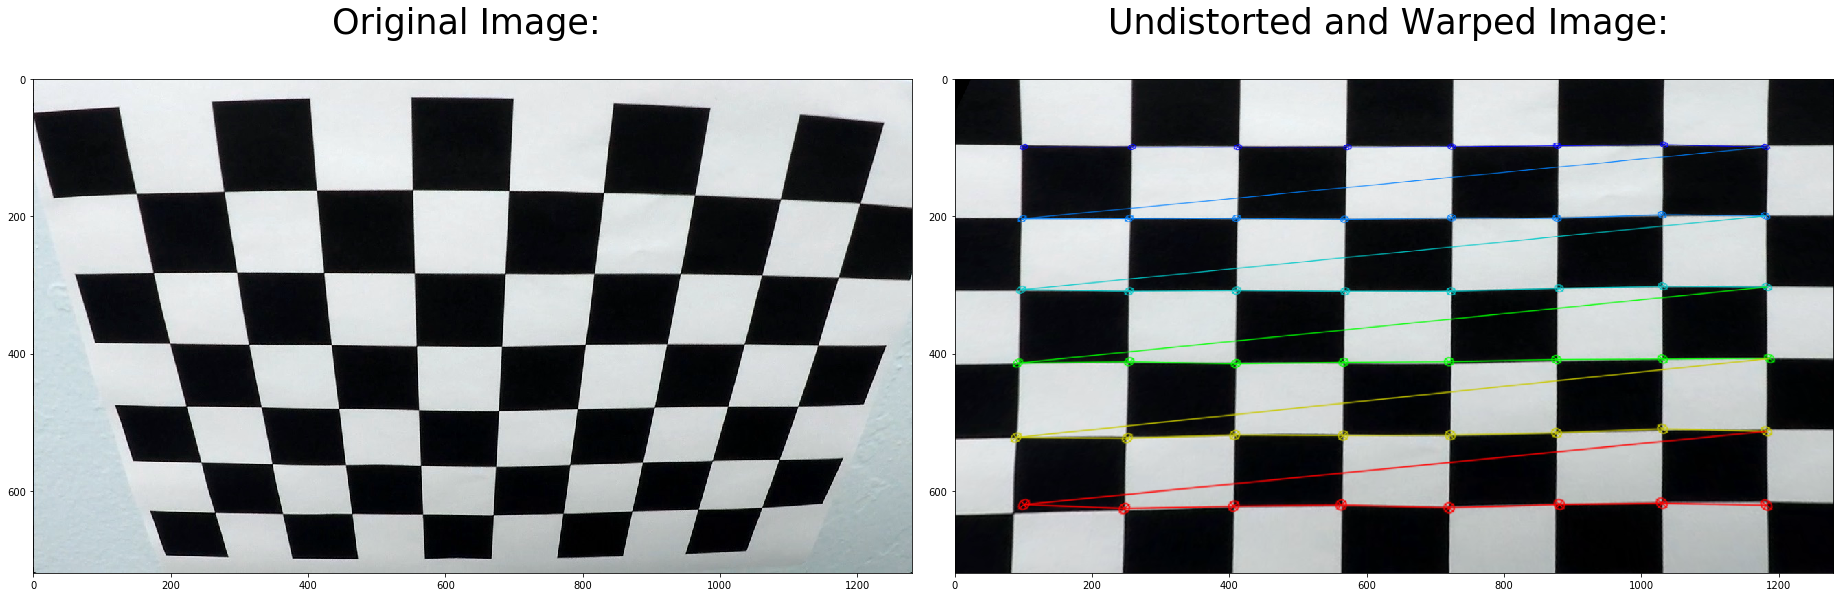

In [4]:
dist_pickle = pickle.load( open( "resources/camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('resources/camera_cal/calibration2.jpg')
nx = 8
ny = 6
def corners_unwarp(img, nx=nx, ny=ny, mtx=mtx, dist=dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0],
                          corners[nx-1],
                          corners[-1],
                          corners[-nx]])
        dst = np.float32([[offset, offset],
                          [img_size[0]-offset, offset],
                          [img_size[0]-offset, img_size[1]-offset], 
                          [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img)
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('resources/output_images/undistorted_and_warped.png', bbox_inches="tight")

In [129]:
def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,7.2))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0}:'.format(plot_title, n+1), fontsize=15)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
def pipeline(op=None):
    test_images = glob.glob('resources/test_images/test*.jpg')
    n = 0
    for img in test_images:
        img = cv2.imread(img)
        test_img = bgr_to_rgb(img)
        if op == 'Undistorted Image':
            new_img = undistort(img)
            plotter(test_img, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('resources/output_images/undistorted.png'.format(op), bbox_inches="tight")
            break
        n += 1

In [128]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def undistort(img):
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)            

pipeline(op='Undistorted Image')

NameError: name 'dist_pickle' is not defined

### Section II: Feature Extraction and Training with a Linear SVM Classifier

##### Visualize the data set.

Total Number of Car Images: 2826
Total Number of Non-Car Images: 8968
Image Size: (64, 64, 3)
Image Type: float32


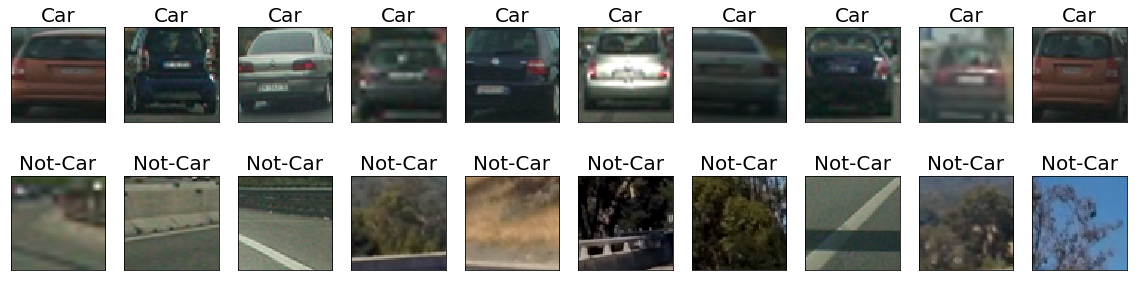

In [4]:
cars_far = glob.glob('resources/datasets/vehicles/GTI_Far/image*.png')
cars_left = glob.glob('resources/datasets/vehicles/GTI_Left/image*.png')
cars_middle = glob.glob('resources/datasets/vehicles/GTI_MiddleClose/image*.png')
cars_right = glob.glob('resources/datasets/vehicles/GTI_Right/image*.png')
cars = cars_far + cars_left + cars_middle + cars_right
shuffle(cars)

not_cars_extras = glob.glob('resources/datasets/non-vehicles/Extras/extra*.png')
not_cars_gti = glob.glob('resources/datasets/non-vehicles/GTI/image*.png')
not_cars = not_cars_extras + not_cars_gti
shuffle(not_cars)

def visualize_data(cars, not_cars):
    data_dict = {}
    data_dict["n_cars"] = len(cars)
    data_dict["n_not_cars"] = len(not_cars)
    img = mpimg.imread(cars[0])
    data_dict["img_shape"] = img.shape
    data_dict["d_type"] = img.dtype
    return data_dict

visual = visualize_data(cars, not_cars)

print('Total Number of Car Images: {0}'.format(visual['n_cars']))
print('Total Number of Non-Car Images: {0}'.format(visual['n_not_cars']))

print('Image Size: {0}\nImage Type: {1}'.format(visual['img_shape'], visual['d_type']))

def random_image(cars, not_cars):
    car_id = np.random.randint(0, len(cars))
    not_car_id = np.random.randint(0, len(not_cars))
    car_image = mpimg.imread(cars[car_id])
    not_car_image = mpimg.imread(not_cars[not_car_id])
    return car_image, not_car_image

n = 0
fig = plt.figure(figsize=(20, 10))
while n < 10:
    car_image, not_car_image = random_image(cars, not_cars)
    fig.add_subplot(1, 10, n+1)
    plt.imshow(not_car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Not-Car', fontsize=20)
    fig.add_subplot(2, 10, n+1)
    plt.imshow(car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Car', fontsize=20)
    n += 1
plt.savefig('resources/output_images/data_visualization.png', bbox_inches="tight")

##### Randomly select an image for visualization.

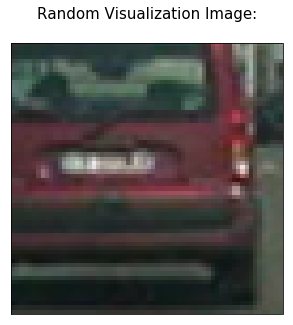

In [84]:
car_id = np.random.randint(0, len(cars))
rand_img = cv2.imread(cars[car_id])
rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(rand_img);
plt.title('Random Visualization Image:\n', fontsize=15)
plt.xticks(()); plt.yticks(());

##### Visualize histograms of color in an image.

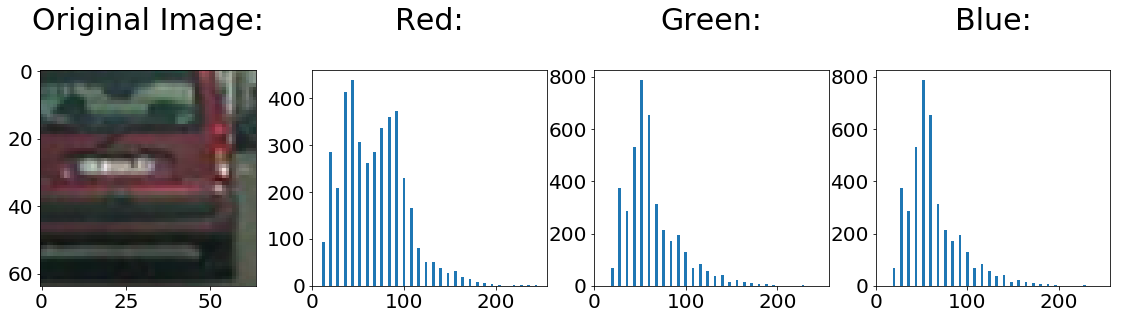

In [148]:
red_hist = np.histogram(rand_img[:,:,0], bins=32, range=(0, 256))
green_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
blue_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))

bin_edges = red_hist[1] #all three bins are the same size
bin_centers = (bin_edges[1:] + bin_edges[00:len(bin_edges) - 1])/2

fig = plt.figure(figsize=(10,3));
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

plt.subplot(1, 4, 1)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=30);

plt.subplot(1, 4, 2)
plt.bar(bin_centers, red_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Red:\n', fontsize=30);

plt.subplot(1, 4, 3)
plt.bar(bin_centers, green_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Green:\n', fontsize=30);

plt.subplot(1, 4, 4)
plt.bar(bin_centers, blue_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Blue:\n', fontsize=30);

plt.subplots_adjust(left=0.5, right=2, top=1, bottom=0.)
plt.savefig('resources/output_images/color_histograms.png', bbox_inches="tight")

##### Visualize the distribution of color in an image.

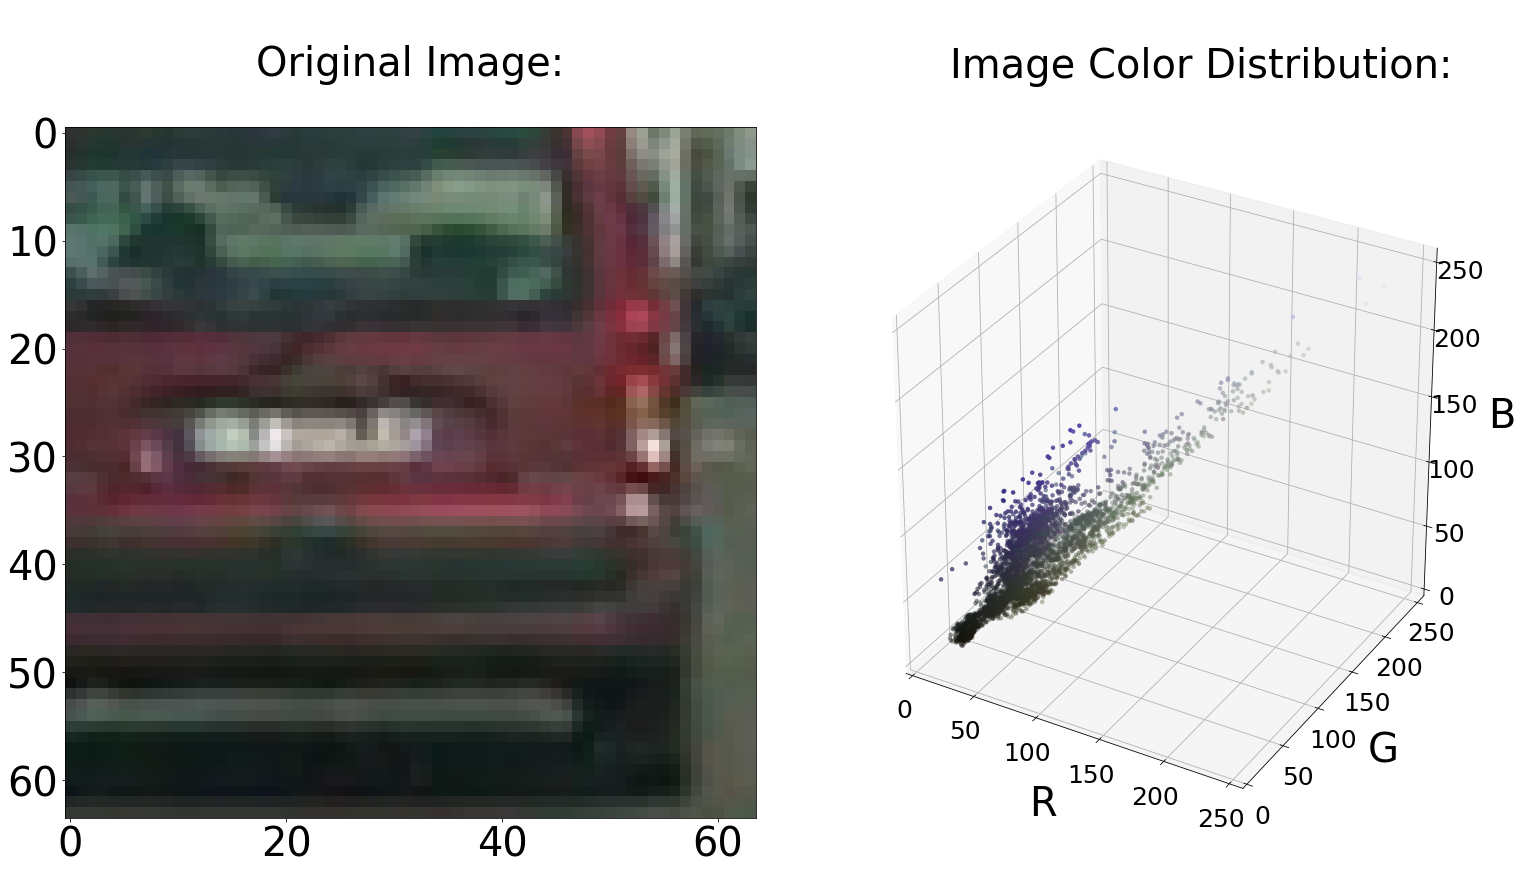

In [121]:
scale = max(rand_img.shape[0], rand_img.shape[1], 64) / 64
img_small = cv2.resize(rand_img, (np.int(rand_img.shape[1] / scale), np.int(rand_img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.

pixels = img_small_RGB
colors_rgb = img_small_rgb
axis_labels = list('RGB')
axis_limits = [(0,255), (0,255), (0,255)]

f = plt.figure(figsize=(20,10));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=40);

ax2 = f.add_subplot(1, 2, 2, projection='3d');
ax2.text2D(1.65, 1.38, "Image Color Distribution:", transform=ax.transAxes, fontsize=40)

ax2.set_xlim(*axis_limits[0])
ax2.set_ylim(*axis_limits[1])
ax2.set_zlim(*axis_limits[2])

ax2.tick_params(axis='both', which='major', labelsize=25, pad=8)
ax2.set_xlabel(axis_labels[0], fontsize=40, labelpad=30)
ax2.set_ylabel(axis_labels[1], fontsize=40, labelpad=30)
ax2.set_zlabel(axis_labels[2], fontsize=40, labelpad=30)

ax2.scatter(pixels[:,:,0].ravel(), pixels[:,:,1].ravel(), pixels[:,:,2].ravel(), c=colors_rgb.reshape((-1, 3)), edgecolors='none');

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('resources/output_images/image_color_distribution.png', bbox_inches="tight")

##### Visualize the spatial binning of color in an image.

##### Visualize gradient features in an image.

##### Visualize HOG features in an image.

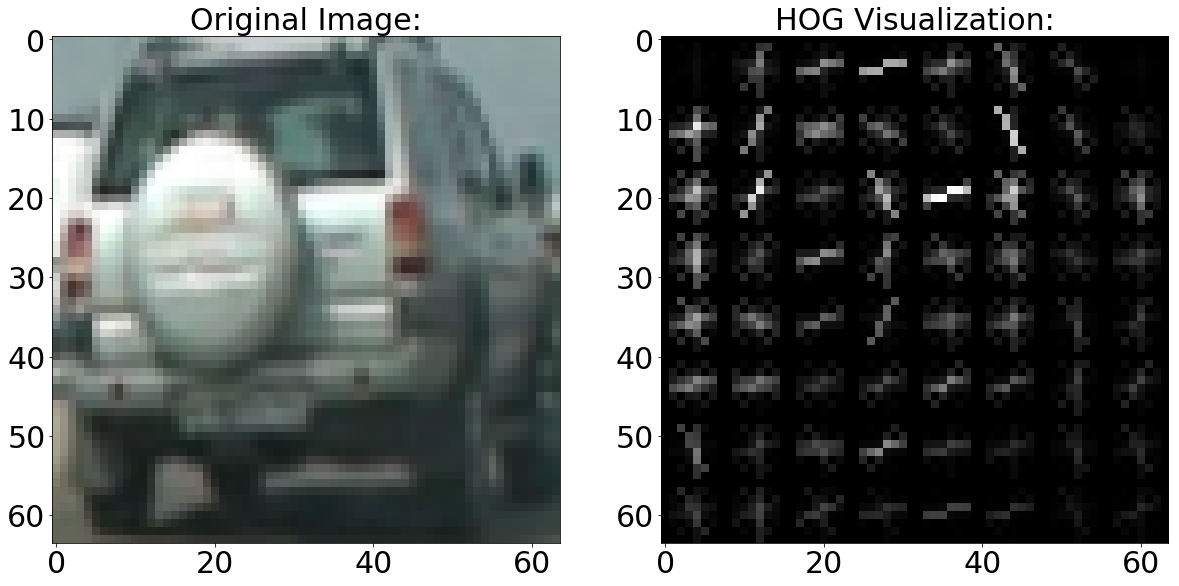

In [35]:
from skimage.feature import hog

hog_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)

features, hog_image = hog(hog_img, 
                          orientations=9, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualise=True,
                          feature_vector=False)

fig = plt.figure(figsize=(20, 10));
fig.add_subplot(121)
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
plt.imshow(img)
plt.title('Original Image:', fontsize=30);
fig.add_subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization:', fontsize=30);

##### Perform feature extraction methods on the labeled training set of images.

In [ ]:
def get_color_histogram(img, n_bins=32, bins_range=(0, 256)):
    red_hist = np.histogram(img[:,:,0], bins=n_bins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=n_bins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=n_bins, range=bins_range)
    bin_edges = red_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))
    return red_hist, green_hist, blue_hist, bin_centers, hist_features

def get_3d_color_plot(pixels, colors_rgb,
                      axis_labels=list("RGB"),
                      axis_limits=[(0, 255), (0, 255), (0, 255)]):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax

def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
'''
hog_features = []

for img in tqdm(cars):
    img = get_hog_features(img, visualization=False)
    hog_features.append(img)
'''

##### Apply color transforms and append binned color features and histograms of color.

##### Normalize Features and Split Training Data for Testing and Validation.

##### Train a Linear SVM classifier using the labeled training set.

### Section III: Search for Vehicles in Images 

##### Implement a sliding-window technique to filter the image for possible vehicles.

##### Apply trained classifier to search for vehicles in sliding-window images.

### Section IV: Test on a Video Stream

##### Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


##### Estimate a bounding box for vehicles detected.

##### Output results as a video.

In [8]:
def video_pipeline(img):
    
    # TO DO
    
    return None

In [9]:
video_output = 'P5_test_video.mp4'
clip = VideoFileClip('resources/test_videos/test_video.mp4')

output_clip = clip.fl_image(video_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#video_output = 'P5_project_video_final.mp4'
#clip = VideoFileClip('resources/test_videos/project_video.mp4')

#output_clip = clip.fl_image(video_pipeline)
#%time output_clip.write_videofile(video_output, audio=False)